In [3]:
import scipy.io as sco
import scipy as sc
from scipy.sparse import coo_matrix 
import matplotlib.pyplot as plt
import copy
import math
import random
import pandas as pd
import numpy as np
import traceback
import logging


# Parameters

In [125]:
sub_matrix_ratio = 0.05         # only to save time for testing use -1 for real application 
random_result = True

path_data = "/Users/mathieuouellet/Dropbox/My Mac (mathieu’s MacBook Pro)/Desktop/Boolean_code_clean/cell_mat.mtx" #path of the data file
temp_path = "./data_example/real_cell/temp/"

fig_distrib = "./fig/real_cell_distribution.pdf"
fig_line = "./fig/real_cell_line.pdf"

n_min = 3000                    # minimum of non_zero 
n_max = 9000                    # maximum of non_zero 

bin_step = 0.01                 # size of binary step for thresholding
diff_med_mean = 0.03            # max distance between median and mean before considering the distribution has a weird tail 


In [63]:
#if we take sub_matrix for speed
if sub_matrix_ratio != -1:
    n_min = n_min*sub_matrix_ratio #minimum of non_zero 
    n_max = n_max*sub_matrix_ratio #maximum of non_zero 
    diff_med_mean = diff_med_mean/sub_matrix_ratio

# Load files 

In [44]:
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != sc.sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * np.ones(matr.shape[0])
    gc = -1 * np.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = np.arange(0, lr)
    ac = np.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return sc.sparse.coo_matrix((matr.data[newelem], np.array([gr[newrows],gc[newcols]])),(lr, lc))

In [45]:
#load the matrix, take a sub matrix if needed 
print("loading")
try:
    main_mat = sco.mmread(path_data)
except Exception as e:
    logging.error(traceback.format_exc())
if sub_matrix_size!=-1:
    new_x = int(sub_matrix_ratio*main_mat.shape[0])
    new_y = int(sub_matrix_ratio*main_mat.shape[1])
    main_mat = coo_submatrix_pull(main_mat, np.array(list(range(new_x))), np.array(list(range(new_y))))
print(main_mat.shape)

loading
(1676, 626)


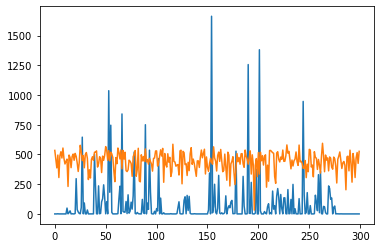

In [46]:
#plot the total number of gene expression for each gene (first 300 genes)
row_sum = main_mat.sum(axis=1)[0:300]
plt.plot(row_sum)
#ratio of non zero
column_nnz = main_mat.getnnz(axis=0).tolist()
plt.plot(column_nnz[0:300])
plt.show()

# Keep gene that are midly expressed/detected ? 

In [47]:
#remove all the one that have less than n_min non zero and the one that have more than n_max non zero
#the goal is to keep the one that arrive quite often but are not always there i.e. not the housekeeping gene

column_id_to_keep = []
column_nnz = main_mat.getnnz(axis=0).tolist()

for i, val in enumerate(column_nnz):
    if val>=n_min and val<=n_max:
        column_id_to_keep.append(i)

print(len(column_id_to_keep))

csr = main_mat.tocsr()

column_translation_middle = np.array(column_id_to_keep)
csr_middle = csr[:,column_id_to_keep]

print(csr_middle.shape)

336
(1676, 336)


In [48]:
path = temp_path + 'column_translation_middle.txt'
csr_middle_txt = temp_path+"csr_middle.txt"
#save a file to translate easily later
if os.path.exists(path):
    os.remove(path)   
with open(path, 'w') as f:
    for item in column_translation_middle:
        str_temp = str(item) +   " \n"
        f.write( str_temp )
#save also in matrix format 
sc.sparse.save_npz(csr_middle_txt, csr_middle)

# define Thresholding method and find threshold for each gene

In [49]:
def otso(hist) :
    n = len(hist)
    hist = np.array(hist)
    
    mean_weigth = 1.0/np.sum(hist)
    final_thresh = -1
    final_value = -1
    for t in range(1,n-1): # This goes from 1 to 254 uint8 range (Pretty sure wont be those values)
        Wb = np.sum(hist[:t]) * mean_weigth
        Wf = np.sum(hist[t:]) * mean_weigth

        mub = np.mean(hist[:t])
        muf = np.mean(hist[t:])

        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value
            
    return final_thresh


def max_threshold(hist) :
    n = len(hist)
    max_val = -100000
    id_max = -1
    
    for i in range(1,n-1):
        if hist[i]>max_val:
            max_val = hist[i]
            id_max = i        
            
    return id_max

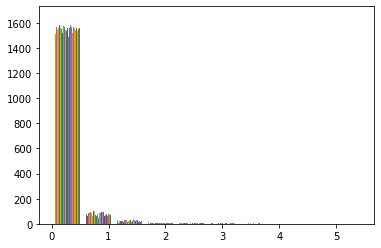

In [54]:
n, bins, patches = plt.hist(csr_middle.toarray())
plt.show()


thresholding
336
0 20 0.2
1 34 0.34
2 17 0.17
3 10 0.1
4 40 0.4
5 23 0.23
6 12 0.12
7 39 0.39
8 19 0.19
9 16 0.16
10 21 0.21
11 40 0.4
12 26 0.26
13 31 0.31
14 16 0.16
15 16 0.16
16 22 0.22
17 15 0.15
18 17 0.17
19 36 0.36
20 15 0.15
21 21 0.21
22 10 0.1
23 17 0.17
24 17 0.17
25 17 0.17
26 18 0.18
27 27 0.27
28 31 0.31
29 22 0.22
30 33 0.33
31 36 0.36
32 15 0.15
33 17 0.17
34 13 0.13
35 13 0.13
36 10 0.1
37 15 0.15
38 23 0.23
39 36 0.36
40 19 0.19
41 41 0.41000000000000003
42 17 0.17
43 19 0.19
44 16 0.16
45 26 0.26
46 26 0.26
47 13 0.13
48 13 0.13
49 15 0.15
50 15 0.15
51 14 0.14
52 19 0.19
53 52 0.52
54 17 0.17
55 10 0.1
56 35 0.35000000000000003
57 14 0.14
58 21 0.21
59 13 0.13
60 13 0.13
61 17 0.17
62 32 0.32
63 14 0.14
64 12 0.12
65 16 0.16
66 24 0.24
67 15 0.15
68 20 0.2
69 17 0.17
70 15 0.15
71 15 0.15
72 12 0.12
73 18 0.18
74 9 0.09
75 13 0.13
76 26 0.26
77 28 0.28
78 14 0.14
79 41 0.41000000000000003
80 42 0.42
81 17 0.17
82 13 0.13
83 19 0.19
84 37 0.37
85 18 0.18
86 12 0.12


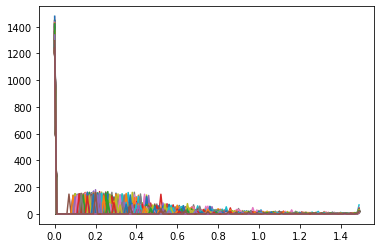

In [64]:
print("thresholding")
threshold_method = max_threshold
bins = np.arange(0, 1.5, bin_step) # fixed bin size

median_list = []
max_list = [] 
mean_list = []
std_list = []

id_mean_equal_median = []
bin_otso_list = []
value_otso_list = []

print(csr_middle.shape[1])

for i in range(csr_middle.shape[1]):
    data = csr_middle[:,i].todense()
    med_val = np.median(data,axis=0)[0,0]
    mean_val = np.mean(data,axis=0)[0,0]
    max_val = np.max(data,axis=0)[0,0]
    std_val = np.std(data,axis=0)[0,0]


    if abs(mean_val-med_val) < diff_med_mean:
        
        median_list.append(med_val)
        mean_list.append(mean_val)
        max_list.append(max_val)
        std_list.append(std_val)
        
        count = [0]*len(bins)
        
        for j in range(data.shape[0]):
            index = round(data[j][0,0]/bin_step)
            if index > len(bins)-1:
                index = len(bins)-1
            
            count[index]+=1
        
        
        bin_id = threshold_method(count[1:]) +1
        print(i,bin_id, bins[bin_id])
        plt.plot(bins, count)
        id_mean_equal_median.append(i)
        bin_otso_list.append(bins)
        value_otso_list.append(bins[bin_id])
plt.show()


In [66]:
csr_middle_equalmedian = csr_middle[:,id_mean_equal_median]
column_translation_middle_equalmedian = column_translation_middle[id_mean_equal_median] 
bin_otso_list = bin_otso_list
value_otso_list = value_otso_list


csr_middle_equalmedian_txt = temp_path + "csr_middle_equalmedian.txt"
path = temp_path + 'column_translation_middle_equalmedian.txt'


sc.sparse.save_npz(csr_middle_equalmedian_txt, csr_middle_equalmedian)
if os.path.exists(path):
    os.remove(path)
with open(path, 'w') as f:
    for item in column_translation_middle_equalmedian:
        str_temp = str(item) +   " \n"
        f.write( str_temp )

        

# normalizing each gene  

In [67]:

csr_middle_equalmedian_scaled = copy.copy(csr_middle_equalmedian)
rn = csr_middle_equalmedian.shape[0]
cn = csr_middle_equalmedian.shape[1]

for column in range(cn):
    
    value_otso = value_otso_list[column]
    std_otso = std_list[column]
    print(column, value_otso)
    
    rows,cols = csr_middle_equalmedian[:,column].nonzero()
        
    for row in rows:
        csr_middle_equalmedian_scaled[row,column] = (csr_middle_equalmedian[row,column] - value_otso)/std_otso
        
    if column%100==0:
        print(csr_middle_equalmedian[row,column])
        

0 0.2
1.6002823868713798
1 0.34
2 0.17
3 0.1
4 0.4
5 0.23
6 0.12
7 0.39
8 0.19
9 0.16
10 0.21
11 0.4
12 0.26
13 0.31
14 0.16
15 0.16
16 0.22
17 0.15
18 0.17
19 0.36
20 0.15
21 0.21
22 0.1
23 0.17
24 0.17
25 0.17
26 0.18
27 0.27
28 0.31
29 0.22
30 0.33
31 0.36
32 0.15
33 0.17
34 0.13
35 0.13
36 0.1
37 0.15
38 0.23
39 0.36
40 0.19
41 0.41000000000000003
42 0.17
43 0.19
44 0.16
45 0.26
46 0.26
47 0.13
48 0.13
49 0.15
50 0.15
51 0.14
52 0.19
53 0.52
54 0.17
55 0.1
56 0.35000000000000003
57 0.14
58 0.21
59 0.13
60 0.13
61 0.17
62 0.32
63 0.14
64 0.12
65 0.16
66 0.24
67 0.15
68 0.2
69 0.17
70 0.15
71 0.15
72 0.12
73 0.18
74 0.09
75 0.13
76 0.26
77 0.28
78 0.14
79 0.41000000000000003
80 0.42
81 0.17
82 0.13
83 0.19
84 0.37
85 0.18
86 0.12
87 0.15
88 0.16
89 0.2
90 0.12
91 0.2
92 0.16
93 0.15
94 0.3
95 0.25
96 0.09
97 0.14
98 0.33
99 0.18
100 0.35000000000000003
0.007976338688788854
101 0.24
102 0.45
103 0.22
104 0.15
105 0.15
106 0.19
107 0.19
108 0.12
109 0.11
110 0.18
111 0.12
112 0.11
113 

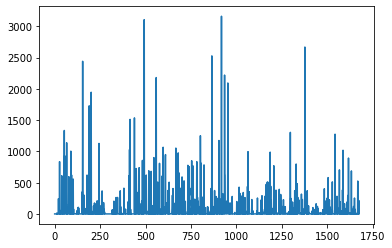

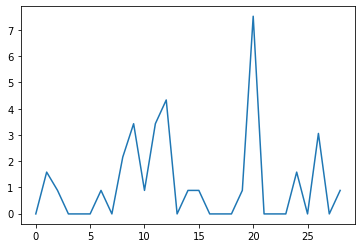

In [71]:
row_sum = csr_middle_equalmedian_scaled.sum(axis=1)
plt.plot(row_sum)
plt.show()
#number of cell for each RNA  
column_test = csr_middle_equalmedian_scaled[:,4].todense()
list_column_test = []

for i in range(200):
    if column_test[i][0,0]!=0:
        list_column_test.append(column_test[i][0,0])

plt.plot(list_column_test)
plt.show()

In [70]:

csr_middle_equalmedian_scaled_txt = temp_path + "csr_middle_equalmedian_scaled.txt"
sc.sparse.save_npz(csr_middle_equalmedian_scaled_txt, csr_middle_equalmedian_scaled)


# define the assymetry metric 

In [72]:
def approx_step(x,k):
    
    return 0.5 + 0.5*math.tanh(x*k)

def distance(a,b,hardness,ring_radius,circle_hardness):
    
    val = abs(((a+b)/(abs(a)+abs(b)+0.0000001)))**hardness
    r = math.sqrt(a**2+b**2)
    
    return max(val, (1-approx_step(r-ring_radius,circle_hardness)))


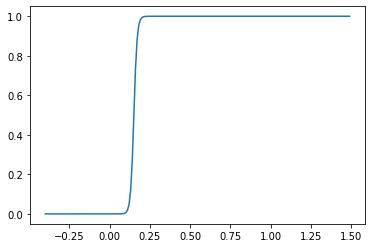

In [73]:
bin_step = 0.01
bins = np.arange(-0.4, 1.5, bin_step)

list_toplot = []


for i in range(len(bins)):
    
    list_toplot.append(approx_step(bins[i]-0.15,50))
    

plt.plot(bins,list_toplot)      
plt.show()

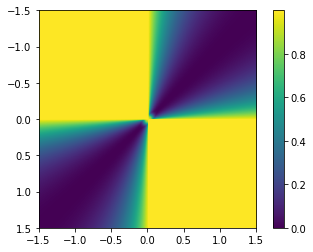

In [74]:

bin_step = 0.01

bins = np.arange(-1.5, 1.5, bin_step) # fixed bin size


mat_toplot = np.zeros((len(bins),len(bins)))


for i in range(len(bins)):
    for j in range(len(bins)):
        
        mat_toplot[i,j] = distance(bins[i],bins[j],2,0.07,25)
        
plt.imshow(mat_toplot,extent=[-1.5, 1.5,1.5,-1.5])
plt.colorbar()


plt.savefig('distance.svg')  



# Keep the cell with both positive and negative (at least 1/3) value of gene

In [77]:
max_n = csr_middle_equalmedian_scaled.shape[0]

good_id = []

for i in range(max_n):
    
    vec1 = csr_middle_equalmedian_scaled[i,:].todense().tolist()
    vec1 = vec1[0]
    
    n_lower = 0
    n_top = 0
    
    for j in range(len(vec1)):
        if vec1[j]<-0.001:
            n_lower+=1 
        if vec1[j]>0.001:
            n_top+=1 
            
            
    if n_top > 0 and n_lower/n_top >0.33:
        good_id.append(i)
    
print(len(good_id))


535


In [78]:
csr_middle_equalmedian_scaled_nobadcell = csr_middle_equalmedian_scaled[good_id, :]

# Test distance function (assymetry metric)

In [82]:
max_n = len(good_id)
mean_matrix = np.zeros((max_n,max_n))
list_mean = []

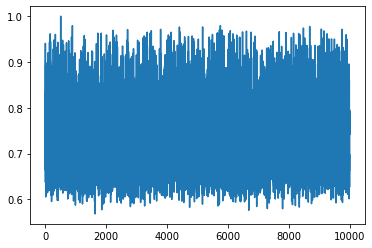

In [57]:
list_of_mean = []

for k in range(10000):
    
    id1 = random.randint(0,max_n-1)
    id2 = random.randint(0,max_n-1)
    
    vec1 = csr_middle_equalmedian_scaled_nobadcell[id1,:].todense().tolist()[0]

    vec2 = csr_middle_equalmedian_scaled_nobadcell[id2,:].todense().tolist()[0]

    vec_dist = []

    for i in range(len(vec1)):

        if vec1[i]!=0 and vec2[i]!=0:
            vec_dist.append(distance(vec1[i],vec2[i],1.7,0.1,25))
        else:
            vec_dist.append(float("Nan"))


    mean = np.nanmean(np.array(vec_dist))

    list_of_mean.append(mean)

plt.plot(list_of_mean)
plt.show()

In [58]:
print(np.mean(np.array(list_of_mean)))
print(np.std(np.array(list_of_mean)))

0.7317766737519406
0.07897804738907395


# Create the mean_matrix of assymetry ratio

In [130]:
less_than_0p6 = []
more_than_0p95 = []

In [131]:
for id1 in range(max_n):
    vec1 = csr_middle_equalmedian_scaled_nobadcell[id1,:].todense().tolist()[0]

    for id2 in range(max_n): 
        
        if id2 > id1:

            vec2 = csr_middle_equalmedian_scaled_nobadcell[id2,:].todense().tolist()[0]

            vec_dist = []

            for i in range(len(vec1)):

                if vec1[i]!=0 and vec2[i]!=0:
                    vec_dist.append(distance(vec1[i],vec2[i],1.7,0.1,25))
                else:
                    vec_dist.append(float("Nan"))


            mean = np.nanmean(np.array(vec_dist))

            
            

            if random_result :
                fake_mean = random.random()
                list_mean.append(fake_mean)
                mean_matrix[id1,id2] = fake_mean
                mean = fake_mean
            else:
                list_mean.append(mean)
                mean_matrix[id1,id2] = mean

            
            if mean<0.6:
                less_than_0p6.append((id1,id2))
            if mean>0.95:
                more_than_0p95.append((id1,id2))
            #we are testing in that case  so make it easier



<ipython-input-131-68674fa25038>:20: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(np.array(vec_dist))


In [132]:
txt_0p6_path = temp_path + 'less_than_0p6.txt'
txt_0p95_path = temp_path + 'more_than_0p95.txt'

if os.path.exists(txt_0p6_path):
    os.remove(txt_0p6_path)

if os.path.exists(txt_0p95_path):
    os.remove(txt_0p95_path)
    
    
with open(txt_0p6_path, 'w') as f:
    for item in less_than_0p6:
        str_temp = str(item[0]) +  " ; " + str(item[1])+ " \n"
        f.write( str_temp )

        
with open(txt_0p95_path, 'w') as f:
    for item in more_than_0p95:
        str_temp = str(item[0]) +  " ; " + str(item[1])+ " \n"
        f.write( str_temp )


In [133]:
csr_middle_equalmedian_scaled_nobadcell_txt = temp_path +"csr_middle_equalmedian_scaled_nobadcell.txt"
sc.sparse.save_npz(csr_middle_equalmedian_scaled_nobadcell_txt, csr_middle_equalmedian_scaled_nobadcell)

In [134]:
path = temp_path +'translate_column.txt'

if os.path.exists(path):
    os.remove(path)
    
with open(path, 'w') as f:
    for item in column_translation_middle_equalmedian:
        str_temp = str(item) + " \n"
        f.write( str_temp )


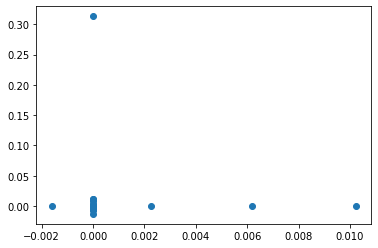

In [135]:
id_tocheck = less_than_0p6[0]
id_tocheck = more_than_0p95[0]
n_test = 6
vec1 = csr_middle_equalmedian_scaled_nobadcell[id_tocheck[0],:].todense().tolist()
vec2 = csr_middle_equalmedian_scaled_nobadcell[id_tocheck[1],:].todense().tolist()
plt.scatter(x=vec1,y=vec2 )
plt.show()
    



In [136]:
v1 = [0.5,0.5]
v2 = [0.5,-0.5]
v3 = [-0.5,-0.25]
v4 = [0.25,-0.25]
ls_vec  = [v1,v2,v3,v4]

for id1 in range(len(ls_vec)): 
    for id2 in range(len(ls_vec)): 
        
        vec_dist = []
        for i in range(len(ls_vec[id1])):

            if ls_vec[id1][i]!=0 and ls_vec[id2][i]!=0:
                vec_dist.append(distance(ls_vec[id1][i],ls_vec[id2][i],1.7,0.1,25))
            else:
                vec_dist.append(float("Nan"))

        print(id1,id2,1-np.nanmean(np.array(vec_dist)), sep=" , ")


0 , 0 , 1.6999997720645865e-07
0 , 1 , 0.5000000849999557
0 , 2 , 0.9227561747132401
0 , 3 , 0.4227562880465858
1 , 0 , 0.5000000849999557
1 , 1 , 1.6999997720645865e-07
1 , 2 , 0.5000001133332801
1 , 3 , 2.2666662580217434e-07
2 , 0 , 0.9227561747132401
2 , 1 , 0.5000001133332801
2 , 2 , 2.5499994271704907e-07
2 , 3 , 0.422756344713227
3 , 0 , 0.4227562880465858
3 , 1 , 2.2666662580217434e-07
3 , 2 , 0.422756344713227
3 , 3 , 3.399999081166172e-07


# Get the value (nres/primed) 

In [137]:
df = pd.read_csv("/Users/mathieuouellet/Dropbox/My Mac (mathieu’s MacBook Pro)/Desktop/Boolean_code_clean/cell_id.txt", delimiter = ";")

In [138]:
list_primed_good = []
list_primed = df['x'].tolist()
for id_tokeep in good_id:
    
    if list_primed[id_tokeep] == "primed":
        list_primed_good.append(1)
    else:
        list_primed_good.append(0)


In [139]:
same_sample_count = 0
diff_sample_count = 0
total_nb_sample = 0

for i in range(100000):
    
    if random.choice(list_primed)==random.choice(list_primed):
        same_sample_count+=1
    else:
        diff_sample_count+=1
        
    total_nb_sample+=1
    

print(same_sample_count/total_nb_sample)
    

0.64949


# Get average of all assymetry matrix 

In [140]:
count_all = 0
sum_all = 0

for id1 in range(max_n):
    
    for id2 in range(max_n): 
        
        if id2 > id1:
            
            count_all+=1
            sum_all+=mean_matrix[id1,id2]

print(sum_all/count_all)
            

0.5019725384143198


# Compute average mirror fate for lower than assymetry ratio

In [141]:


bin_step = 0.005

bins = np.arange(0.5, 0.73, bin_step)

same_count_list = [0]*len(bins)
diff_count_list = [0]*len(bins)

for id1 in range(max_n):
    
    for id2 in range(max_n): 
        
        if id2 > id1:
            
            mean = mean_matrix[id1,id2]
            
            for i in range(len(bins)):
                
                if bins[i]>mean:
                    
                    if list_primed_good[id1] == list_primed_good[id2]:
                        same_count_list[i]+=1
                    else:
                        diff_count_list[i]+=1

                
                

# Compute average mirror fate for higher than assymetry ratio

In [142]:

bin_step = 0.005

bins = np.arange(0.735, 0.95, bin_step)

same_count_list_higher = [0]*len(bins)
diff_count_list_higher = [0]*len(bins)

list_all_mean = []

for id1 in range(max_n):
    
    for id2 in range(max_n): 
        
        if id2 > id1:
            
            mean = mean_matrix[id1,id2]
            list_all_mean.append(1-mean)
            
            for i in range(len(bins)):
                
                if bins[i]<mean:
                    
                    if list_primed_good[id1] == list_primed_good[id2]:
                        same_count_list_higher[i]+=1
                    else:
                        diff_count_list_higher[i]+=1

                

            

In [143]:
fffff = [0.1]

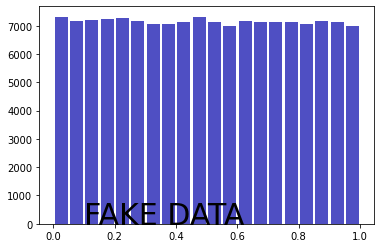

In [144]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=list_all_mean, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.text(0.1, 0.6, "FAKE DATA", fontsize=30)
plt.savefig(fig_distrib, transparent=True)
 

In [145]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
step_size = 0.1
list_bin = [k*step_size for k in range(1, int(1/step_size)+1)]
value_bin = [0]*len(list_bin)


# 

# Plot below and higher curve

### test symmetry of each gene 

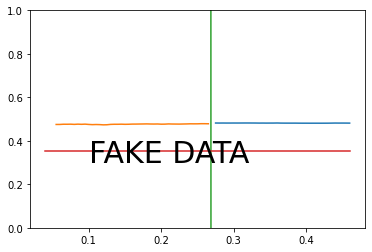

In [146]:
new_bins = np.arange(0.5, 0.73, bin_step)[8:]
new_same_count_list = same_count_list[8:]
new_diff_count_list = diff_count_list[8:]

new_bins_higher = np.arange(0.735, 0.95, bin_step)
new_same_count_list_higher = same_count_list_higher
new_diff_count_list_higher = diff_count_list_higher


ratio = [0]*len(new_same_count_list)
ratio_higher = [0]*len(new_diff_count_list_higher)



for i in range(len(new_same_count_list)):
    
    ratio[i]=new_same_count_list[i]/(new_same_count_list[i]+new_diff_count_list[i])

    
for i in range(len(new_diff_count_list_higher)):
    
    ratio_higher[i]=new_same_count_list_higher[i]/(new_same_count_list_higher[i]+new_diff_count_list_higher[i])
    

revert_new_bins = [1-x for x in new_bins]
revert_new_bins_higher = [1-x for x in new_bins_higher]

revert_ratio = [1-x for x in ratio]
revert_ratio_higher = [1-x for x in ratio_higher]
    
plt.ylim([0, 1])   
plt.plot(revert_new_bins, revert_ratio)
plt.plot(revert_new_bins_higher, revert_ratio_higher)
plt.plot([1-0.7314971694889372,1-0.7314971694889372+0.0001], [1-0,1-1])
plt.plot([1-0.54,1-0.96], [1-0.64599,1-0.64599])
plt.text(0.1, 0.3, "FAKE DATA", fontsize=30)

plt.savefig(fig_line)  
